# Border

Optimized compactness extraction - faster code

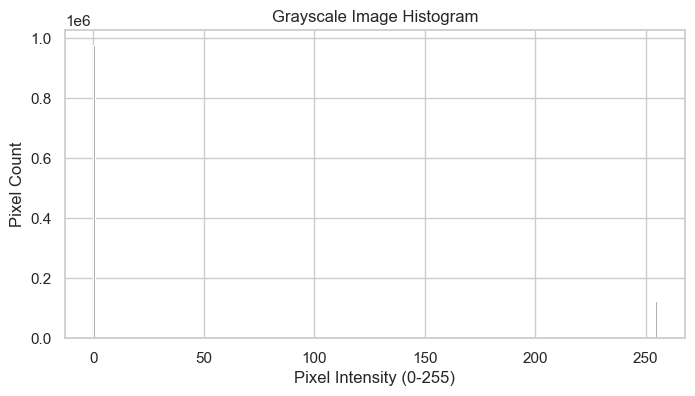

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load image as grayscale
file_im = './data/lesion_masks/PAT_8_15_820_mask.png'
im = cv2.imread(file_im, cv2.IMREAD_GRAYSCALE)

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(im.flatten(), bins=256, color='gray')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Pixel Count')
plt.title('Grayscale Image Histogram')
plt.show()

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

#Boarder extraction feature using classical compactness formula, but optimized courner detection techniques
def B_compactness(m):
    #converting image to gray scale (remove before working with classifier) -> should be binary
    mask = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
    #function used to find all detected borders, shapes
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #extracting the largest boarder, furthest from the center with largest area
    largest_contour = max(contours, key=cv2.contourArea)
    #computes euclidean distancesfor perimeter determination, close = True for closed countour shape
    perimeter = cv2.arcLength(largest_contour, closed=True)
    #calculates area using Green’s Theorem treating contour as a polygon
    area = cv2.contourArea(largest_contour)
    #calculating compactness using classical formula
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    return compactness


The code that we were provided by last year students - slow running time

In [121]:
import pandas as pd
import numpy as np
import os
import numpy as np
import cv2
from skimage import morphology

def get_compactness(mask_path):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Convert to binary boolean mask
    mask = mask > 0  # Now it's a boolean array, as required

    area = np.sum(mask)
    if area == 0:
        return 0

    struct_el = morphology.disk(3)

    try:
        mask_eroded = morphology.binary_erosion(mask, struct_el)
        perimeter = np.sum(mask & ~mask_eroded)  # Boolean logic
    except Exception as e:
        print(f"Error processing {mask_path}: {e}")
        return 0

    if perimeter == 0:
        return 0

    return round((4 * np.pi * area) / (perimeter ** 2), 4)

In [194]:
# Load your DataFrame
data = pd.read_csv('feature_extraction_set.csv')

# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['compactness'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = B_compactness(mask_path)
            data.at[idx, 'compactness'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['compactness_std'] = scaler.fit_transform(data[['compactness']])

In [196]:
data

,diagnostic,img_id,img_base,compactness
0,1,PAT_106_159_325.png,PAT_106_159_325,0.694909
1,0,PAT_107_160_609.png,PAT_107_160_609,0.827416
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.890640
3,0,PAT_26_37_865.png,PAT_26_37_865,0.825954
4,1,PAT_98_152_562.png,PAT_98_152_562,0.795918
...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.776006
116,1,PAT_135_202_593.png,PAT_135_202_593,0.700059
117,1,PAT_90_138_605.png,PAT_90_138_605,0.781715
118,1,PAT_160_249_76.png,PAT_160_249_76,0.838848


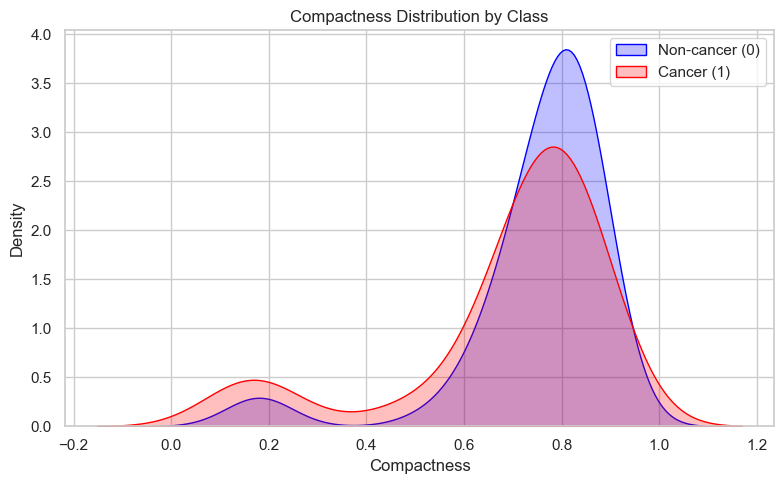

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='compactness', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='compactness', label='Cancer (1)', fill=True, color='red')

plt.title('Compactness Distribution by Class')
plt.xlabel('Compactness')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()



# Asymetry

In [198]:
import cv2
import numpy as np
from math import floor, ceil
from skimage.transform import rotate

#Main call -> mean_asymmetry

"""Calculating asymetry score by rotating image 4 times(90 degrees) and calculating
asymetry each time"""

def cut_mask(mask):
    """Removing big part of black background to avoid misleading 
    asymetry and computational cost"""
    rows = np.any(mask, axis=1) #rows that have white pixels
    cols = np.any(mask, axis=0) #columns that have white pixels

    row_min, row_max = np.where(rows)[0][[0, -1]] #indexes of white rows
    col_min, col_max = np.where(cols)[0][[0, -1]] #indexes of white columns

    return mask[row_min:row_max+1, col_min:col_max+1] #bounding box of the lesion

def find_midpoint(image):
    """Mid point detection of the lesion, where image is grayscale mask"""
    return image.shape[0] // 2, image.shape[1] // 2 #middle row, middle column (x,y)

def asymmetry(mask):
    """Measuring shape asymetry of the mask"""
    row_mid, col_mid = find_midpoint(mask) #middle point

    #splitting the mask into 4 halves
    upper = mask[:row_mid, :]
    lower = mask[-row_mid:, :]
    left = mask[:, :col_mid]
    right = mask[:, -col_mid:]

    #flipping bottom and right half
    flipped_lower = np.flipud(lower) #flip up
    flipped_right = np.fliplr(right) #flip left

    #the following codes are used to ensure that when halves are compared,
    #the arrays have the same sizes for np.logical_xor() to work
    hmin = min(upper.shape[0], flipped_lower.shape[0]) #picks the smallest number of rows
    vmin = min(left.shape[1], flipped_right.shape[1]) #picks the smallest number of columns

    #counting mismatched pixels
    hori_xor = np.logical_xor(upper[:hmin, :], flipped_lower[:hmin, :])
    vert_xor = np.logical_xor(left[:, :vmin], flipped_right[:, :vmin])

    #calculating the area -> sum of the white pixels
    total = np.sum(mask)
    if total == 0: #if mask is black to avoid division by zero error
        return np.nan

    #calculating the asymetry score (0 perfect symetry, 1 very asymetric)
    score = (np.sum(hori_xor) + np.sum(vert_xor)) / (2 * total) 
    #total mismatch standardized by total pixels in lesion tp get score 0 to 1
    return round(score, 4)

def rotation_asymmetry(mask, n=4):
    """Rotating the picture n times and getting asymetry 
    scores for every rotation"""
    asymmetry_scores = []

    for i in range(n):
        deg = 360 * i / n
    #optimization, if the angle is multiple of 90 use np.rot90 which is faster than rotate function
        if deg % 90 == 0:
            k = int(deg // 90)
            rotated = np.rot90(mask, k)
        else:
            rotated = rotate(mask, deg, preserve_range=True, order=0).astype(np.uint8)

        cropped = cut_mask(rotated > 0)#creating a binary bounded lesion, avoiding interpolation artifacts
        score = asymmetry(cropped)
        asymmetry_scores.append(score)

    return asymmetry_scores

def mean_asymmetry(path, rotations=4):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if mask is None: #check if mask exists
        return np.nan
    mask = (mask > 0).astype(np.uint8) #binarizing because mask is in gray scale

    scores = rotation_asymmetry(mask, rotations)
    return round(np.nanmean(scores), 4)



In [199]:
# Folder with lesion masks
mask_dir = './data/lesion_masks/'

# Initialize empty column
data['asymmetry'] = np.nan

# Efficient iteration
for idx, row in data.iterrows():
    base_name = row['img_base']
    mask_path = os.path.join(mask_dir, f"{base_name}_mask.png")

    if os.path.isfile(mask_path):
        try:
            score = mean_asymmetry(mask_path)
            data.at[idx, 'asymmetry'] = score
        except Exception as e:
            print(f"Error at {mask_path}: {e}")
    else:
        print(f"Missing mask: {mask_path}")

In [200]:
data

,diagnostic,img_id,img_base,compactness,asymmetry
0,1,PAT_106_159_325.png,PAT_106_159_325,0.694909,0.1232
1,0,PAT_107_160_609.png,PAT_107_160_609,0.827416,0.1024
2,0,PAT_289_1399_481.png,PAT_289_1399_481,0.890640,0.0380
3,0,PAT_26_37_865.png,PAT_26_37_865,0.825954,0.0887
4,1,PAT_98_152_562.png,PAT_98_152_562,0.795918,0.0646
...,...,...,...,...,...
115,1,PAT_131_197_260.png,PAT_131_197_260,0.776006,0.0900
116,1,PAT_135_202_593.png,PAT_135_202_593,0.700059,0.1231
117,1,PAT_90_138_605.png,PAT_90_138_605,0.781715,0.0981
118,1,PAT_160_249_76.png,PAT_160_249_76,0.838848,0.1156


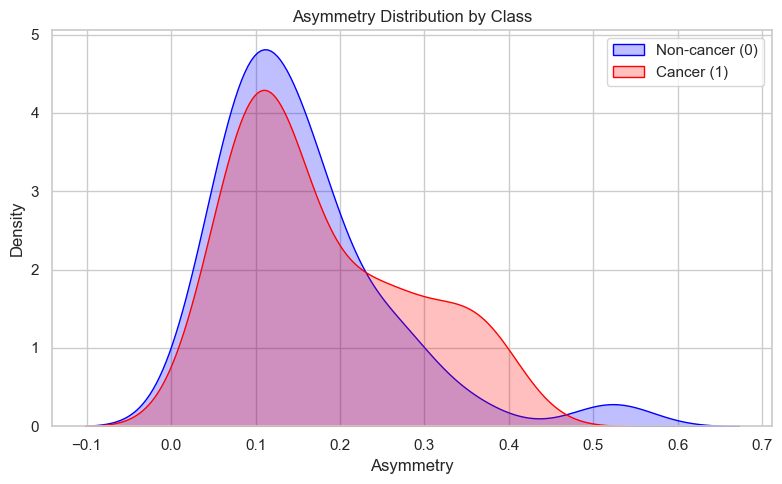

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'data' with columns 'compactness' and 'diagnostic'
plt.figure(figsize=(8, 5))
sns.kdeplot(data=data[data['diagnostic'] == 0], x='asymmetry', label='Non-cancer (0)', fill=True, color='blue')
sns.kdeplot(data=data[data['diagnostic'] == 1], x='asymmetry', label='Cancer (1)', fill=True, color='red')

plt.title('Asymmetry Distribution by Class')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()